Por favor, faça o upload do seu arquivo CSV.


Saving sensor_data_completed.csv to sensor_data_completed.csv

Dados carregados com sucesso!

Novas features (SDNN, pNN50) calculadas com sucesso.
Primeiras linhas com as novas features:
  userState   vfcRmssd       sdnn      pnn50
0   Ansioso  42.606729  36.775671  11.111111
1  Relaxado  47.928187  74.212128  44.444444
2   Ansioso  24.195959  25.633767   0.000000
3   Ansioso  28.223316  16.413409   0.000000
4   Ansioso  24.756593  16.898521  11.111111

Dados preparados e divididos para treino e teste.

Iniciando o treinamento do modelo com as novas features...
Treinamento concluído!

Acurácia do modelo no conjunto de teste: 93.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

    Relaxado       0.93      0.93      0.93        15
     Ansioso       0.93      0.93      0.93        15

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.

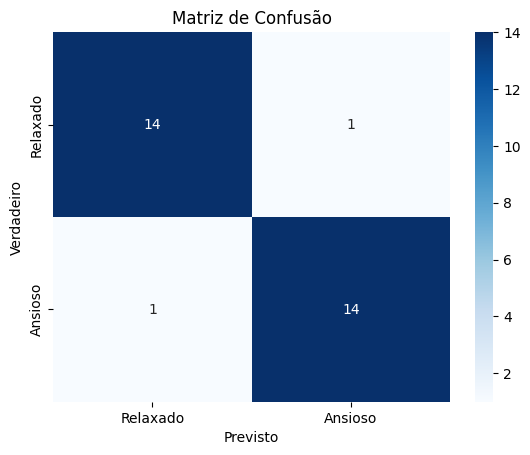

Saved artifact at '/tmp/tmp6sb9esei'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  136983241653136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136983241654096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136983241651024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136983241652176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136983241653712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136983241651600: TensorSpec(shape=(), dtype=tf.resource, name=None)

Modelo v2 convertido para TensorFlow Lite e salvo como 'mental_state_model_v2.tflite'.

COPIE ESTES NOVOS VALORES PARA O SEU CÓDIGO ANDROID:
// Features: value, vfcRmssd, sdnn, pnn50
private val SCALER_MEAN = floatArrayOf(69.50181249062895f, 42.49310372551363f, 27.774291277921908f, 21.347222222222225f)
p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Por favor, faça o upload do seu arquivo CSV.")
uploaded = files.upload()

file_name = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print("\nDados carregados com sucesso!")

df_hr = df[df['sensorType'] == 'HEART_RATE'].copy()
df_hr.dropna(subset=['vfcRmssd', 'ibiListRaw'], inplace=True)


def parse_ibi_list(ibi_string):
    try:

        return [int(x) for x in ibi_string.strip('[]"').split(',')]
    except (ValueError, AttributeError):

        return []


df_hr['ibi_list'] = df_hr['ibiListRaw'].apply(parse_ibi_list)


def calculate_sdnn(ibi_list):
    if len(ibi_list) < 2:
        return 0.0
    return np.std(ibi_list)

def calculate_pnn50(ibi_list):
    if len(ibi_list) < 2:
        return 0.0
    diffs = np.diff(ibi_list)
    count_over_50 = np.sum(np.abs(diffs) > 50)
    return (count_over_50 / len(diffs)) * 100


df_hr['sdnn'] = df_hr['ibi_list'].apply(calculate_sdnn)
df_hr['pnn50'] = df_hr['ibi_list'].apply(calculate_pnn50)

print("\nNovas features (SDNN, pNN50) calculadas com sucesso.")
print("Primeiras linhas com as novas features:")
print(df_hr[['userState', 'vfcRmssd', 'sdnn', 'pnn50']].head())

features = ['value', 'vfcRmssd', 'sdnn', 'pnn50']
X = df_hr[features].values


target_map = {'Relaxado': 0, 'Ansioso': 1}
y = df_hr['userState'].map(target_map).values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print("\nDados preparados e divididos para treino e teste.")

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("\nIniciando o treinamento do modelo com as novas features...")
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.2, verbose=0)
print("Treinamento concluído!")

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAcurácia do modelo no conjunto de teste: {accuracy * 100:.2f}%")

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\nRelatório de Classificação:")
target_names = [k for k, v in sorted(target_map.items(), key=lambda item: item[1])]
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

model_filename = 'mental_state_model_v2.tflite'
with open(model_filename, 'wb') as f:
    f.write(tflite_model)

print(f"\nModelo v2 convertido para TensorFlow Lite e salvo como '{model_filename}'.")


scaler_mean = scaler.mean_
scaler_scale = scaler.scale_

print("\n" + "="*60)
print("COPIE ESTES NOVOS VALORES PARA O SEU CÓDIGO ANDROID:")
print(f"// Features: value, vfcRmssd, sdnn, pnn50")
print(f"private val SCALER_MEAN = floatArrayOf({scaler_mean[0]}f, {scaler_mean[1]}f, {scaler_mean[2]}f, {scaler_mean[3]}f)")
print(f"private val SCALER_SCALE = floatArrayOf({scaler_scale[0]}f, {scaler_scale[1]}f, {scaler_scale[2]}f, {scaler_scale[3]}f)")
print("="*60 + "\n")

print("Iniciando o download do arquivo do modelo v2...")
files.download(model_filename)
